<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-3)" data-toc-modified-id="Общее-впечатление-(ревью-3)-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 3)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Проверка-моделей" data-toc-modified-id="Проверка-моделей-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Проверка моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #графики
from statsmodels.tsa.seasonal import seasonal_decompose #декомпозиция(тренд, сезонность)
#деление выборок/подбор гиперпараметров/ кросс-валидация для временных рядов
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit 
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import  make_scorer
from sklearn.metrics import mean_squared_error #mse


In [281]:
# чтение файла
try:
    df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv',index_col=[0], parse_dates=[0])

#сортировка индексов по возрастанию    
df.sort_index(inplace=True)   
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [282]:
#проверка на монотонность ( расположение в хронологическом порядке)
df.index.is_monotonic

True

In [283]:
#просмотр общей информации
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [284]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Количество заказов колеблется от 0 до 119 шт, в среднем 13 заказов час поступает.
Выполним ресеплинг по часу(изменение интервала на час)

In [285]:
#ресемплинг по одному часу (изменение интервала на час)
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [286]:
#просмотр общей информации с учетом изменений
print(df.describe())

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


Теперь датасет отображает суммарное количество заказов в час.  Количество заказов такси варьируется от 0 до 462 в час

## Анализ

Чтобы лучше понимать временной ряд, разберём тренды и сезонность.

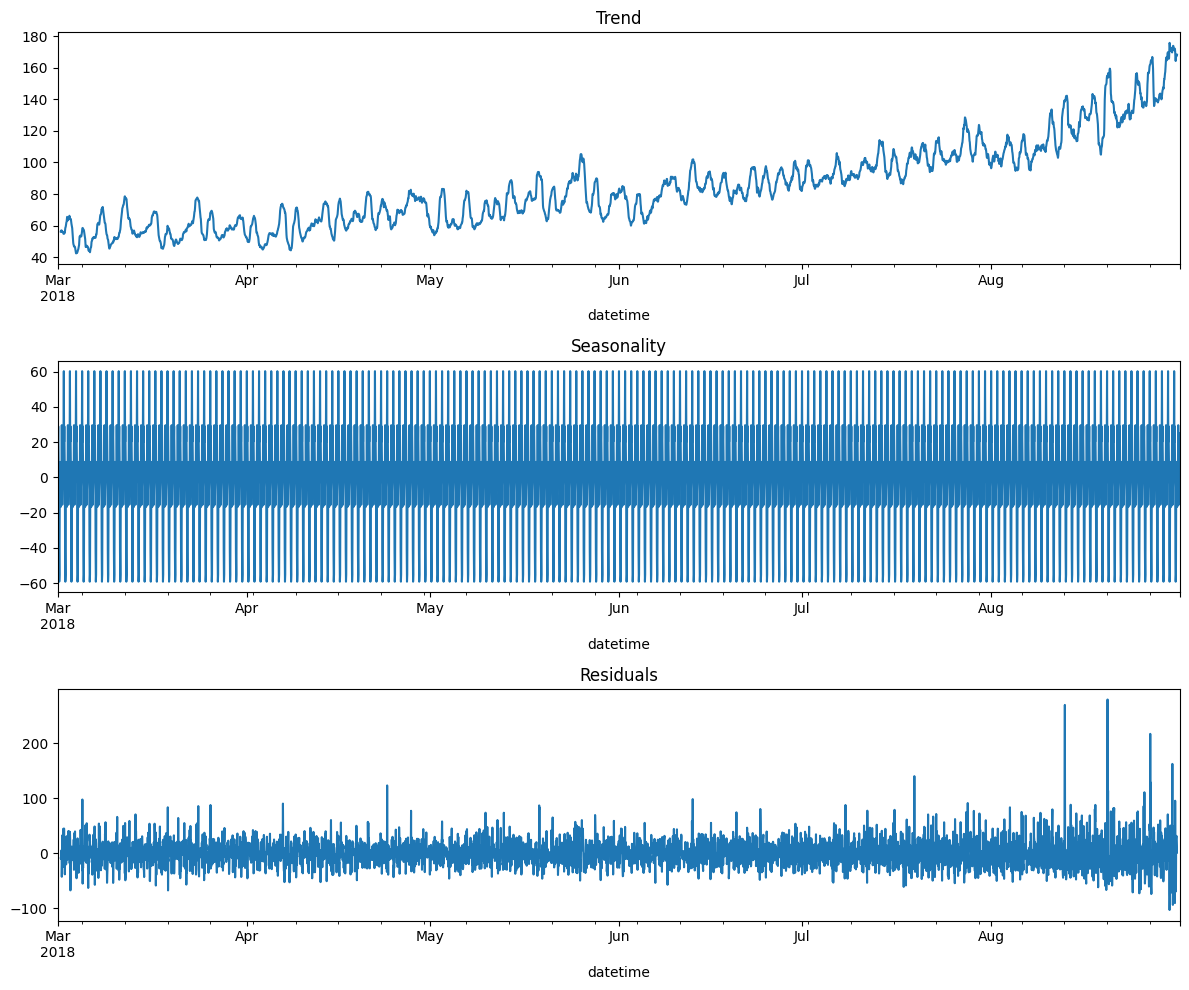

In [287]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(12, 10))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis, получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()
plt.show()


В целом, наблюдается тренд к увеличение заказов на такси. Действительно с каждым годом такси становится доступнее и покупательская способность растет, больше людей предпочитают пользоваться услугами такси, что является более удобным видом транспорта. Второй график иллюстрирует стохастический стационарный процесс. Остатки увеличиваются в конце периода.
Изучим  заказы за последние неделю



In [288]:
# последняя дата в датасете
df.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

Text(0.5, 1.0, 'Seasonality for last week')

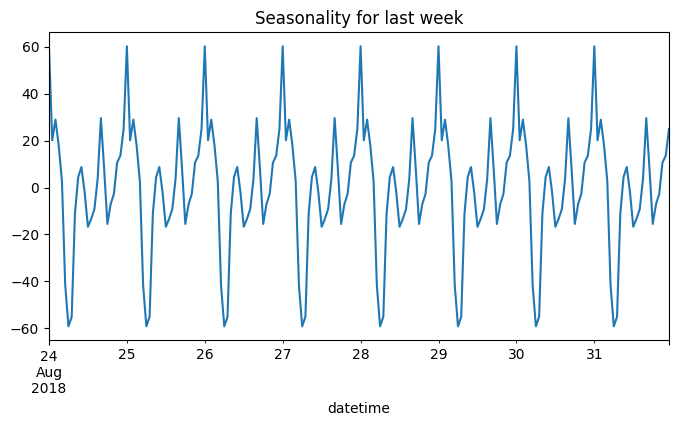

In [289]:
# график заказов за неделю
decomposed.seasonal['2018-08-24':'2018-08-31'].plot(figsize=(8, 4))
plt.title('Seasonality for last week')



Услуги такси актуальны каждый день. Посмотрим заказы за последние 2 дня.

Text(0.5, 1.0, 'Seasonality for last two  day')

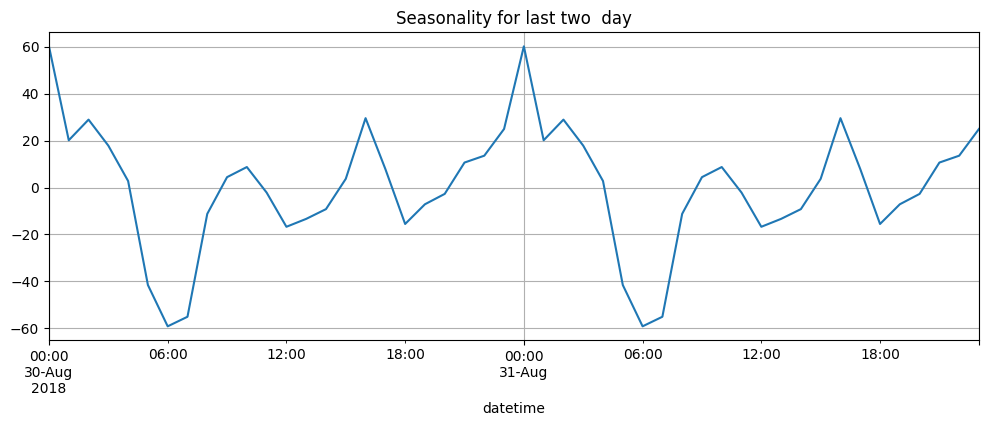

In [290]:
# график заказов за послелдние 2 дня
decomposed.seasonal['2018-08-30':'2018-08-31'].plot(figsize=(12, 4),grid=True)
plt.title('Seasonality for last two  day')


В ночное время наибольший спрос на такси(c 00 до 03), в 06 утра наблюдается спад, также заметны пики в 10 и в 16.

Создадим дополнительные признаки для обучения: календарные признаки,отстающие значения и скользящее среднее.
 В календарные признаки внесем  день,день недели,час

In [291]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    #отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    #скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new


In [293]:
# новая таблица с признаками
#max_lag =24*7 (одна неделя)
df_new = make_features(df, 24*7, 6)
df_new.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разделим датасет на обучающую и тестовую выборку, тестовая выборка размером 10% от исходных данных.

In [294]:
#деление на обучающую и тестовую(10%) выборку
train, test = train_test_split(df_new, shuffle=False, test_size=0.1)
# удаление из обучающей выборки строк с пустыми значениями(исторических данных по ним нет)
train = train.dropna()

print('Размер обучающей выборки:', train.shape)
print('Размер тестовой выборки:', test.shape)

Размер обучающей выборки: (3806, 173)
Размер тестовой выборки: (442, 173)


Проверим корректность деления, тестовая выборка должна следовать обучающей 

In [295]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-08 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Данные разбили корректно, обучащая выборка заканчивается 13 августа в 13:00, тестовая выборка начинается со следующего часа, хронология не нарушена.

Выделим в выборках признаки и целевой признак.

In [296]:
#признаки и целевой признак для обучающей выборки
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
#признаки и целевой признак для тестовой выборки
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

#проверка
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)


(3806, 172)
(3806,)
(442, 172)
(442,)


Признаки подготовлены к дальнейшему обучению моделей

## Обучение

Напишем функцию расчета RMSE для всех моделей

In [297]:
#функция для расчета rmse модели
def rmse(model):
    model.fit(features_train, target_train)
    y_pred = model.predict(features_train)
    rmse = mean_squared_error(target_train,y_pred) ** 0.5
    
    return rmse

Рассмотрим следующие модели: LinearRegression, RandomForestRegressor,LightGBM, CatBoost

Воспользуемся кросс-валидацией для временных рядов:

In [298]:
tssplit = TimeSeriesSplit(n_splits=3)

### LinearRegression

In [308]:
%%time
#параметры для проведения GridSearchCV (подбор лучших параметров)
model = LinearRegression()
parameters_LR = {}
scorer = make_scorer(mean_squared_error, greater_is_better=False)

#подбор параметров модели 
grid_LR = GridSearchCV(estimator= model, param_grid=parameters_LR, cv=5, scoring = scorer)
grid_LR.fit(features_train, target_train)

#запуск обучения(с использованием функции)
rmse_LR = rmse(grid_LR.best_estimator_)


best_model_LR = grid_LR.best_estimator_
best_score_LR = grid_LR.best_score_

#print(f'Результат RMSE: {round(rmse_LR)} заказов')
print(f'Лучшая модель: {best_model_LR}')
print(f'Лучший результат RMSE: {round((best_score_LR *(-1))**0.5,2)} заказов')

Лучшая модель: LinearRegression()
Лучший результат RMSE: 21.49 заказов
CPU times: user 1.01 s, sys: 916 ms, total: 1.93 s
Wall time: 224 ms


### RandomForestRegressor 

In [312]:
%%time
#параметры для проведения GridSearchCV (подбор лучших параметров)
model = RandomForestRegressor()
parameters_Forest = {'max_depth': [10, 15],
                 'n_estimators': [ 150, 200],
                 'min_samples_split': [ 4, 6]}

scorer = make_scorer(mean_squared_error, greater_is_better=False)

grid_Forest = GridSearchCV(estimator= model, param_grid=parameters_Forest, cv=tssplit, scoring = scorer)
grid_Forest.fit(features_train, target_train)

#запуск обучения(с использованием функции)
#rmse_Forest = rmse(grid_Forest.best_estimator_)

best_score_Forest = grid_Forest.best_score_
best_model_Forest = grid_Forest.best_estimator_


#print(f'Результат RMSE: {round(rmse_Forest)} заказов')
print(f'Лучшая модель: {best_model_Forest}')
print(f'Лучший результат RMSE: {round((best_score_Forest *(-1))**0.5,2)} заказов')


Лучшая модель: RandomForestRegressor(max_depth=10, min_samples_split=4, n_estimators=150)
Лучший результат RMSE: 23.77 заказов
CPU times: user 6min 45s, sys: 2.02 s, total: 6min 47s
Wall time: 6min 49s


### LightGBM

In [313]:
%%time
model  = LGBMRegressor()
parameters_lgbm = {'num_leaves': [30,50],
                 'n_estimators': [100, 200],
                  'learning_rate': [0.05, 0.1]}

scorer = make_scorer(mean_squared_error, greater_is_better=False)
grid_lgbm = GridSearchCV(estimator= model, param_grid=parameters_lgbm, cv=tssplit, scoring = scorer)
grid_lgbm.fit(features_train, target_train)

#запуск обучения(с использованием функции)
rmse_lgbm = rmse(grid_lgbm.best_estimator_)


best_model_lgbm = grid_lgbm.best_estimator_
best_score_lgbm = grid_lgbm.best_score_


#print(f'Результат RMSE: {round(rmse_lgbm)} заказов')
print(f'Лучшая модель: {best_model_lgbm}')
print(f'Лучший результат RMSE: {round((best_score_lgbm *(-1))**0.5,2)} заказов')

Лучшая модель: LGBMRegressor(learning_rate=0.05, n_estimators=200, num_leaves=50)
Лучший результат RMSE: 23.92 заказов
CPU times: user 2min 43s, sys: 8.11 s, total: 2min 51s
Wall time: 17 s


### CatBoost

In [314]:
%%time
model = CatBoostRegressor(loss_function='RMSE', silent=True)
parameters_catboost = {'iterations': [50,60,70],
                'depth':[2,5],
                  'learning_rate': [0.05, 0.1]}
scorer = make_scorer(mean_squared_error, greater_is_better=False)

grid_catboost = GridSearchCV(estimator= model, param_grid=parameters_catboost, cv=tssplit, scoring = scorer )
grid_catboost.fit(features_train, target_train)

#запуск обучения(с использованием функции)
rmse_catboost = rmse(grid_catboost.best_estimator_)

best_model_catboost = grid_catboost.best_estimator_
best_score_catboost = grid_catboost.best_score_

#print(f'Результат RMSE: {round(rmse_catboost)} заказов')
print(f'Лучшая модель: {best_model_catboost}')
print(f'Лучший результат RMSE: {round((best_score_catboost *(-1))**0.5,2)} заказов')


Лучшая модель: <catboost.core.CatBoostRegressor object at 0x13f8d0d90>
Лучший результат RMSE: 23.7 заказов
CPU times: user 51.8 s, sys: 2.05 s, total: 53.9 s
Wall time: 7.51 s


### Проверка моделей

Спрогнозировать временные ряды без обучения можно двумя способами:
- Все значения предсказываются одним и тем же числом (константой)
- Новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1).

In [151]:
%%time
# прогноз константной (первый способ)
pred_median = np.ones(target_train.shape) * target_train.median()
rmse_constant = mean_squared_error( pred_median, target_train)**0.5
print("RMSE:", round(rmse_constant))


RMSE: 39
CPU times: user 1.79 ms, sys: 1.22 ms, total: 3.01 ms
Wall time: 2.02 ms


In [142]:
%%time
#прогноз предыдущих значений (второй способ)
pred_previous = train['num_orders'].shift(fill_value=train.iloc[-1,0])
rmse_prev = mean_squared_error( pred_previous, train['num_orders'])** 0.5
print("RMSE:", round(rmse_prev,0))


RMSE: 36.0
CPU times: user 1.91 ms, sys: 3.08 ms, total: 4.99 ms
Wall time: 7.44 ms


In [315]:
#оформление итогов в виде таблицы

print('\033[1m' + '\nСравнение качества на трейне ' + '\033[0m')

df_total = {'RMSE на train, заказов': [round((best_score_LR *(-1))**0.5,2),
                                       round((best_score_Forest *(-1))**0.5,2),
                                       round((best_score_lgbm *(-1))**0.5,2),
                                       round((best_score_catboost *(-1))**0.5,2),
                                       round(rmse_constant,2),
                                       round(rmse_prev,2)],
            'Время обучения,сек ':['224 ms', '6min 49s ', '17 s', '7.51 s', '2.02 ms', '7.44 ms' ],
           }


#pd.set_option('display.float_format', '{:.2f}'.format)
table__total = pd.DataFrame(df_total)

table__total.index = ['LinearRegression', 'RandomForest','LightGBM','CatBoost', 'Constant', 'Constant_previous']

display(table__total)


Сравнение качества на трейне 


,"RMSE на train, заказов","Время обучения,сек"
LinearRegression,21.49,224 ms
RandomForest,23.77,6min 49s
LightGBM,23.92,17 s
CatBoost,23.70,7.51 s
Constant,38.82,2.02 ms
Constant_previous,36.35,7.44 ms


## Тестирование

Лучший результат показала модель LinearRegression. Проверим на тестовой выборке

In [304]:
predict_test = best_model_LR.predict(features_test)
rmse_test = mean_squared_error(target_test,predict_test)**0.5
print(f'RMSE на тестовой выборке: {round(rmse_test,0)} заказов')

RMSE на тестовой выборке: 35.0 заказов


Оформление в виде таблицы предсказания на тестовой выборке

In [310]:
predicted = pd.DataFrame(predict_test, index=features_test.index)

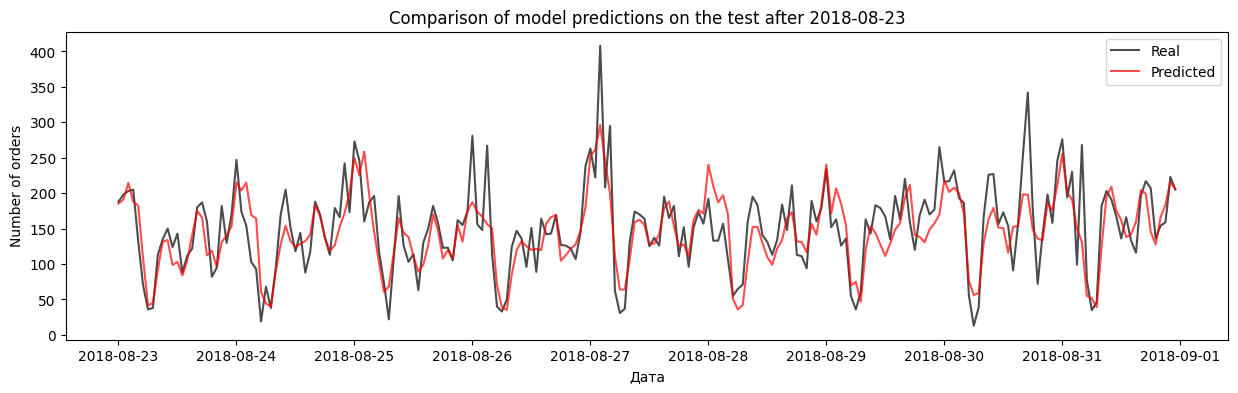

In [311]:
plt.figure(figsize=(15,4))
plt.plot(target_test['2018-08-23':], 
         color='black', 
         alpha=0.7)

plt.plot(predicted['2018-08-23':], 
         color='red', 
         alpha=0.7)

plt.title('Comparison of model predictions on the test after 2018-08-23')
plt.ylabel('Number of orders')
plt.xlabel('Дата')
plt.legend(['Real', 'Predicted'])
plt.show()

### Вывод: 
Все наши модели предсказывают значения лучше константной. Минимальная RMSE (21 заказов) у LinearRegression. На тестовой выборке 35 заказов в ближайший час. Большее значение на тестовой в связи с восходящим трендом заказов со временем.